# Event Feature Visualization

This notebook loads and visualizes event features from the UCFCrime dataset.

**Note**: The `.npy` files contain feature embeddings `[T, d]` from Event-CLIP encoder, not raw pixel data. We visualize these high-level semantic features.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from IPython.display import display
from ipywidgets import interact, IntSlider, Dropdown, SelectMultiple
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## 1. Data Loader

In [7]:
class EventFeatureLoader:
    """Load event features by video_id, class, and segment."""
    
    def __init__(self, data_root='/mnt/Data_1/UCFCrime_dataset/vitb', split='event_thr_10'):
        self.data_root = Path(data_root)
        self.split = split
        self.split_dir = self.data_root / split
        
        # Get all classes
        self.classes = sorted([d.name for d in self.split_dir.iterdir() if d.is_dir()])
        print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # Index all files
        self._index_files()
    
    def _index_files(self):
        """Create an index of all available videos and segments."""
        self.file_index = {}  # {class_name: {video_id: [seg_0, seg_1, ...]}}
        
        for cls in self.classes:
            cls_dir = self.split_dir / cls
            files = sorted(cls_dir.glob('*.npy'))
            
            video_segments = {}
            for f in files:
                # Parse filename: VideoName__SegNum.npy
                match = re.match(r'(.+?)__(\d+)\.npy', f.name)
                if match:
                    video_id, seg_idx = match.group(1), int(match.group(2))
                    if video_id not in video_segments:
                        video_segments[video_id] = []
                    video_segments[video_id].append(seg_idx)
            
            # Sort segments for each video
            for vid in video_segments:
                video_segments[vid] = sorted(video_segments[vid])
            
            self.file_index[cls] = video_segments
        
        print(f"\nIndexed files:")
        for cls in self.classes[:3]:  # Show first 3 classes
            n_videos = len(self.file_index[cls])
            print(f"  {cls}: {n_videos} videos")
    
    def load_segment(self, class_name, video_id, seg_idx):
        """Load a specific segment."""
        filename = f"{video_id}__{seg_idx}.npy"
        filepath = self.split_dir / class_name / filename
        
        if not filepath.exists():
            raise FileNotFoundError(f"Segment not found: {filepath}")
        
        features = np.load(filepath)
        return features
    
    def get_video_ids(self, class_name):
        """Get all video IDs for a class."""
        return sorted(self.file_index.get(class_name, {}).keys())
    
    def get_segments(self, class_name, video_id):
        """Get all segment indices for a video."""
        return self.file_index.get(class_name, {}).get(video_id, [])
    
    def load_all_segments(self, class_name, video_id):
        """Load all segments for a video."""
        seg_indices = self.get_segments(class_name, video_id)
        segments = []
        for seg_idx in seg_indices:
            features = self.load_segment(class_name, video_id, seg_idx)
            segments.append(features)
        return segments, seg_indices

In [8]:
# Initialize loader
loader = EventFeatureLoader(split='event_thr_25')

Found 14 classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Indexed files:
  Abuse: 50 videos
  Arrest: 50 videos
  Arson: 50 videos


## 2. Visualize Single Segment

In [9]:
def visualize_segment(features, title="Event Features"):
    """Visualize a single segment's features."""
    T, d = features.shape
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 1. Feature heatmap
    im = axes[0].imshow(features.T, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[0].set_title(f'{title} - Feature Heatmap', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Temporal Step', fontsize=12)
    axes[0].set_ylabel('Feature Dimension', fontsize=12)
    plt.colorbar(im, ax=axes[0], label='Activation')
    
    # 2. Temporal evolution (mean activation)
    mean_act = features.mean(axis=1)
    std_act = features.std(axis=1)
    axes[1].plot(mean_act, linewidth=2, color='navy', label='Mean activation')
    axes[1].fill_between(range(T), mean_act - std_act, mean_act + std_act, 
                          alpha=0.3, color='skyblue', label='±1 std')
    axes[1].set_title('Temporal Evolution (Mean Activation)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Temporal Step', fontsize=12)
    axes[1].set_ylabel('Activation Value', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Feature statistics over time
    max_act = features.max(axis=1)
    min_act = features.min(axis=1)
    axes[2].plot(max_act, linewidth=2, color='red', label='Max activation', alpha=0.7)
    axes[2].plot(min_act, linewidth=2, color='blue', label='Min activation', alpha=0.7)
    axes[2].plot(mean_act, linewidth=2, color='green', label='Mean activation', alpha=0.7)
    axes[2].set_title('Feature Statistics Over Time', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Temporal Step', fontsize=12)
    axes[2].set_ylabel('Activation Value', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nFeature Statistics:")
    print(f"  Shape: {features.shape}")
    print(f"  Mean: {features.mean():.4f}")
    print(f"  Std: {features.std():.4f}")
    print(f"  Min: {features.min():.4f}")
    print(f"  Max: {features.max():.4f}")

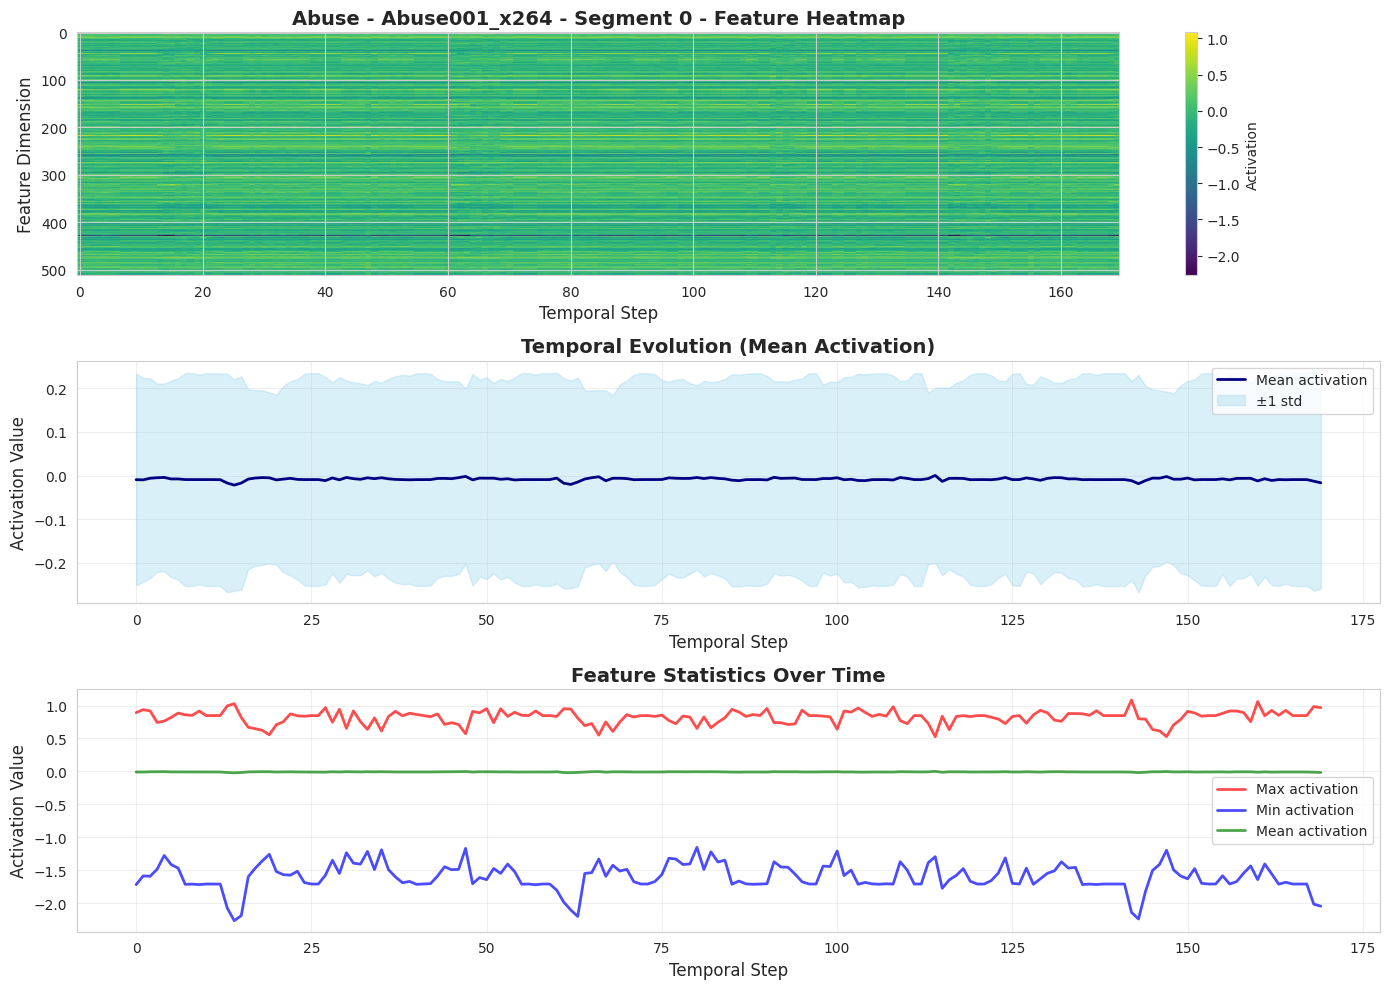


Feature Statistics:
  Shape: (170, 512)
  Mean: -0.0083
  Std: 0.2301
  Min: -2.2681
  Max: 1.0842


In [10]:
# Example: Load and visualize a single segment
class_name = 'Abuse'
video_id = 'Abuse001_x264'
seg_idx = 0

features = loader.load_segment(class_name, video_id, seg_idx)
visualize_segment(features, title=f"{class_name} - {video_id} - Segment {seg_idx}")

## 3. Interactive Segment Browser

In [11]:
def interactive_segment_viewer():
    """Interactive widget to browse segments - OPTIMIZED VERSION."""
    from ipywidgets import interactive_output, VBox
    
    # Create widgets
    class_dropdown = Dropdown(
        options=loader.classes,
        value=loader.classes[0],
        description='Class:'
    )
    
    initial_videos = loader.get_video_ids(class_dropdown.value)
    video_dropdown = Dropdown(
        options=initial_videos,
        value=initial_videos[0] if initial_videos else None,
        description='Video ID:'
    )
    
    initial_segs = loader.get_segments(class_dropdown.value, video_dropdown.value)
    seg_slider = IntSlider(
        value=0,
        min=0,
        max=initial_segs[-1] if initial_segs else 0,
        description='Segment:',
        continuous_update=False
    )
    
    # Update callbacks
    def on_class_change(change):
        videos = loader.get_video_ids(change['new'])
        video_dropdown.options = videos
        video_dropdown.value = videos[0] if videos else None
    
    def on_video_change(change):
        segments = loader.get_segments(class_dropdown.value, change['new'])
        seg_slider.max = segments[-1] if segments else 0
        seg_slider.value = 0
    
    class_dropdown.observe(on_class_change, names='value')
    video_dropdown.observe(on_video_change, names='value')
    
    # Display function (called by interactive_output)
    def display_segment(class_name, video_id, seg_idx):
        try:
            features = loader.load_segment(class_name, video_id, seg_idx)
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 4))
            
            # Heatmap
            im = axes[0].imshow(features.T, aspect='auto', cmap='viridis', interpolation='nearest')
            axes[0].set_title(f'{class_name} - {video_id} - Seg {seg_idx}', fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Temporal Step')
            axes[0].set_ylabel('Feature Dim')
            plt.colorbar(im, ax=axes[0])
            
            # Temporal evolution
            mean_act = features.mean(axis=1)
            axes[1].plot(mean_act, linewidth=2, color='navy')
            axes[1].set_title('Mean Activation Over Time', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Temporal Step')
            axes[1].set_ylabel('Activation')
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Shape: {features.shape} | Mean: {features.mean():.4f} | Std: {features.std():.4f}")
        except Exception as e:
            print(f"Error: {e}")
    
    # Use interactive_output (more efficient than interact)
    out = interactive_output(display_segment, {
        'class_name': class_dropdown,
        'video_id': video_dropdown, 
        'seg_idx': seg_slider
    })
    
    # Display layout
    display(VBox([class_dropdown, video_dropdown, seg_slider, out]))

## 5. Compare Multiple Segments Side-by-Side

In [12]:
def compare_segments(segments_list, titles):
    """Compare multiple segments side by side."""
    n = len(segments_list)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
    
    if n == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (features, title) in enumerate(zip(segments_list, titles)):
        # Heatmap
        im = axes[0, idx].imshow(features.T, aspect='auto', cmap='viridis', interpolation='nearest')
        axes[0, idx].set_title(title, fontsize=11, fontweight='bold')
        axes[0, idx].set_xlabel('Time')
        if idx == 0:
            axes[0, idx].set_ylabel('Feature Dim')
        plt.colorbar(im, ax=axes[0, idx])
        
        # Mean activation
        mean_act = features.mean(axis=1)
        axes[1, idx].plot(mean_act, linewidth=2, color='navy')
        axes[1, idx].set_xlabel('Time')
        if idx == 0:
            axes[1, idx].set_ylabel('Mean Activation')
        axes[1, idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

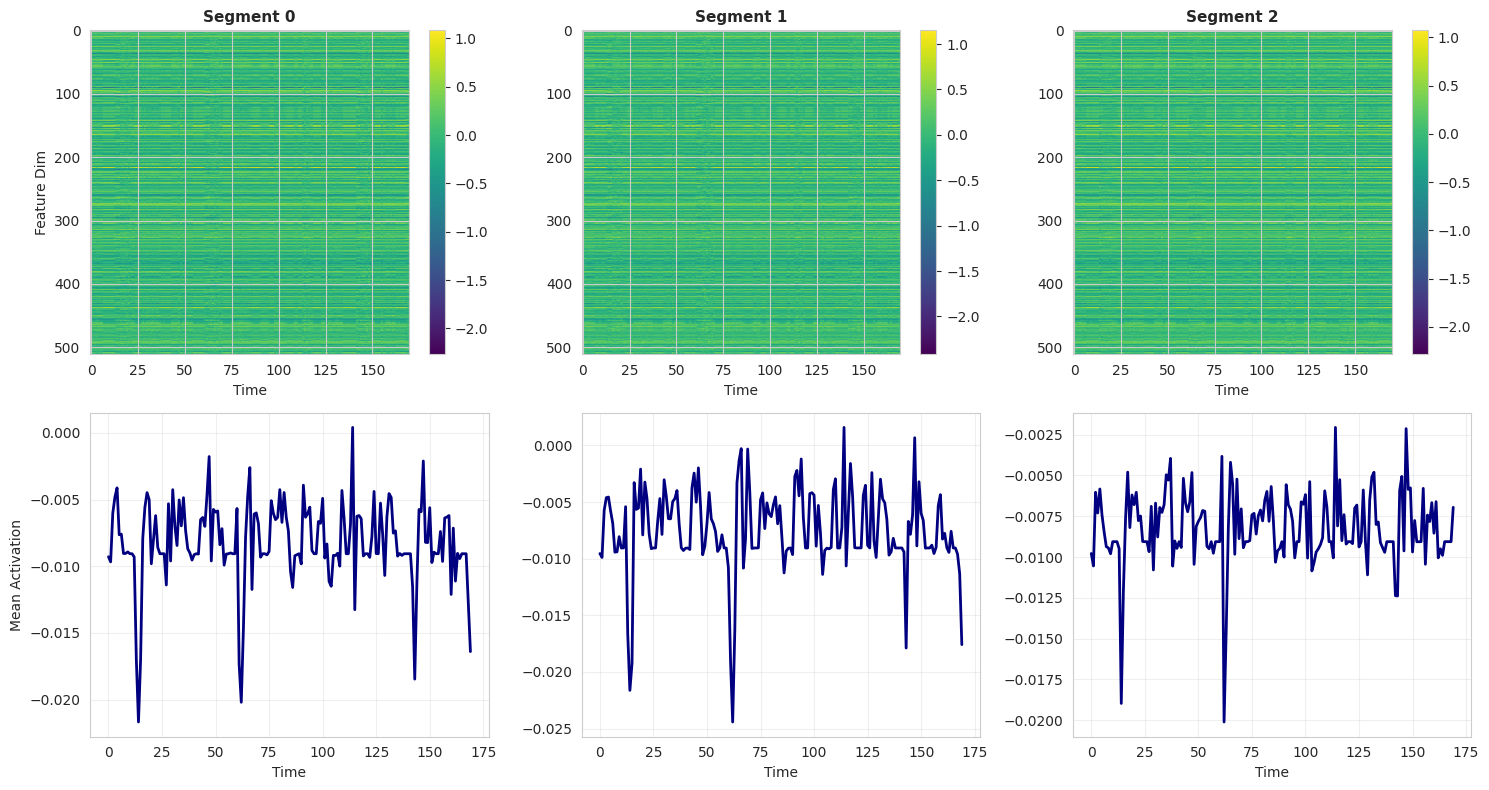

In [13]:
# Example: Compare first 3 segments
seg0 = loader.load_segment('Abuse', 'Abuse001_x264', 0)
seg1 = loader.load_segment('Abuse', 'Abuse001_x264', 1)
seg2 = loader.load_segment('Abuse', 'Abuse001_x264', 2)

compare_segments(
    [seg0, seg1, seg2],
    ['Segment 0', 'Segment 1', 'Segment 2']
)

## 6. Compare Event Thresholds (10 vs 25)

Found 14 classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Indexed files:
  Abuse: 50 videos
  Arrest: 50 videos
  Arson: 50 videos
Found 14 classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Indexed files:
  Abuse: 50 videos
  Arrest: 50 videos
  Arson: 50 videos
Found 14 classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Indexed files:
  Abuse: 50 videos
  Arrest: 50 videos
  Arson: 50 videos


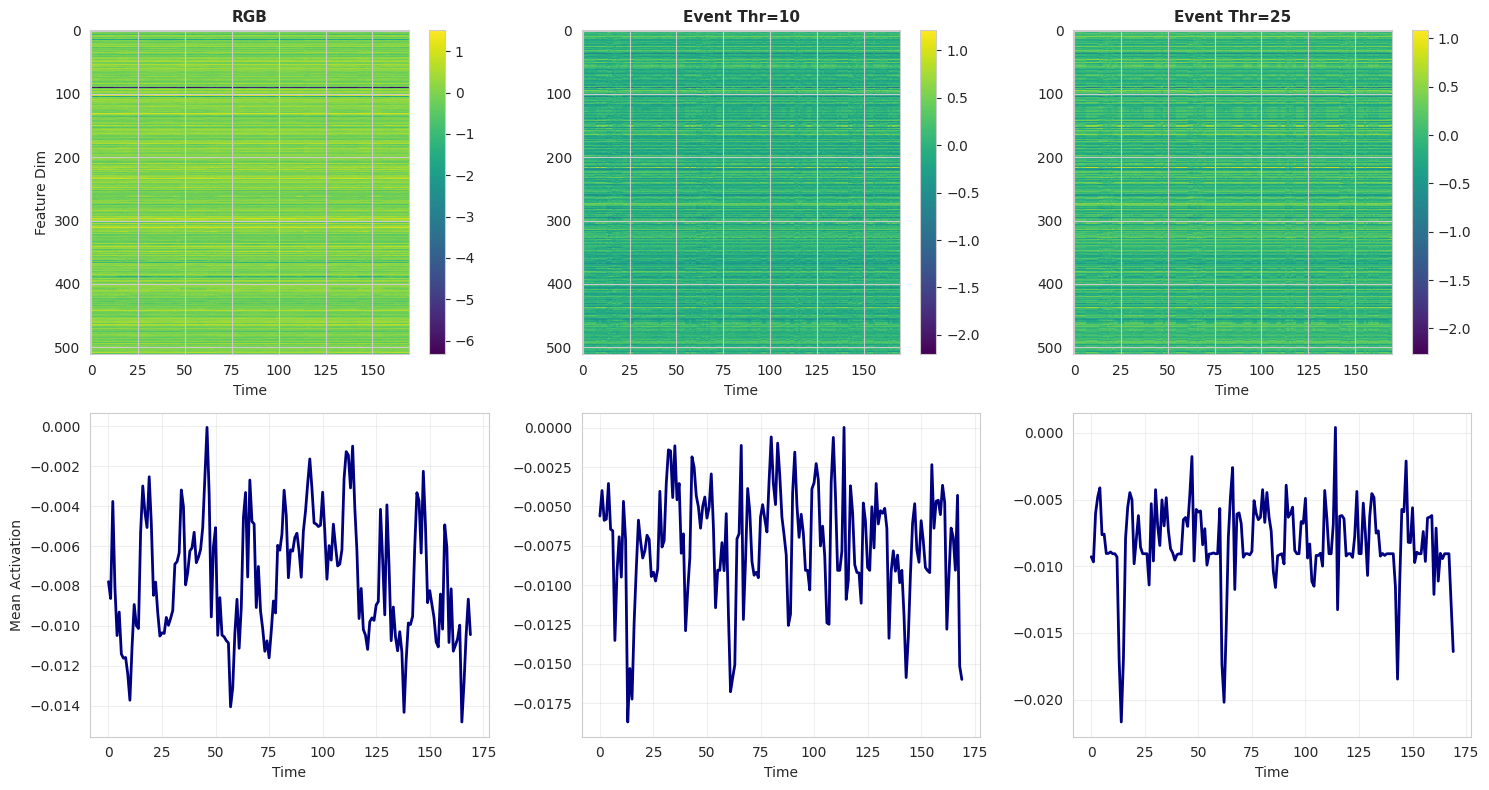

In [14]:
# Load same segment from different thresholds
loader_10 = EventFeatureLoader(split='event_thr_10')
loader_25 = EventFeatureLoader(split='event_thr_25')
loader_rgb = EventFeatureLoader(split='rgb')

class_name = 'Abuse'
video_id = 'Abuse001_x264'
seg_idx = 0

feat_10 = loader_10.load_segment(class_name, video_id, seg_idx)
feat_25 = loader_25.load_segment(class_name, video_id, seg_idx)
feat_rgb = loader_rgb.load_segment(class_name, video_id, seg_idx)

compare_segments(
    [feat_rgb, feat_10, feat_25],
    ['RGB', 'Event Thr=10', 'Event Thr=25']
)

## 7. Interactive Segment Viewer

Run this cell to launch the interactive widget browser. This is placed at the end to avoid blocking other cells.

In [ ]:
# Run interactive viewer
interactive_segment_viewer()